# Proximal Policy Optimization (PPO)

**The foundation of stable RLHF training**

## What is PPO?

**Proximal Policy Optimization (PPO)** is a policy gradient RL algorithm that has become the gold standard for RLHF. It solves the fundamental challenge: **how to improve a policy without breaking it**.

PPO is what powers ChatGPT, Claude, and most modern aligned language models.

## The Problem: Policy Gradient Instability

Vanilla policy gradient is:

$$\nabla_\theta J(\theta) = \mathbb{E} \left[ \nabla_\theta \log \pi_\theta(a | s) \cdot R \right]$$

**The problem:** This is extremely unstable! A "reasonable" gradient step can cause catastrophic changes in policy behavior.

## The PPO Objective

PPO adds **clipping** to prevent large policy changes:

$$L^{\text{CLIP}}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]$$

where:
- $r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}$ is the **probability ratio**
- $\hat{A}_t$ is the **advantage estimate**
- $\epsilon$ is the **clipping threshold** (typically 0.2)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_ppo_loss(
    logprobs: torch.Tensor,
    old_logprobs: torch.Tensor,
    advantages: torch.Tensor,
    clip_ratio: float = 0.2
) -> torch.Tensor:
    """
    Compute PPO clipped surrogate loss.
    
    Args:
        logprobs: Log probs under current policy
        old_logprobs: Log probs under old policy (from rollout)
        advantages: Advantage estimates
        clip_ratio: Clipping threshold (epsilon)
    
    Returns:
        PPO loss (to minimize)
    """
    # Compute probability ratio
    log_ratio = logprobs - old_logprobs
    ratio = torch.exp(log_ratio)
    
    # Unclipped objective
    unclipped = ratio * advantages
    
    # Clipped objective
    clipped_ratio = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio)
    clipped = clipped_ratio * advantages
    
    # Take minimum (conservative update)
    loss = -torch.min(unclipped, clipped).mean()
    
    return loss

# Example
batch_size = 16
logprobs = torch.randn(batch_size) - 2
old_logprobs = torch.randn(batch_size) - 2
advantages = torch.randn(batch_size)

loss = compute_ppo_loss(logprobs, old_logprobs, advantages)
print(f"PPO Loss: {loss.item():.4f}")

PPO Loss: -0.1216


## Visualizing the Clipped Objective

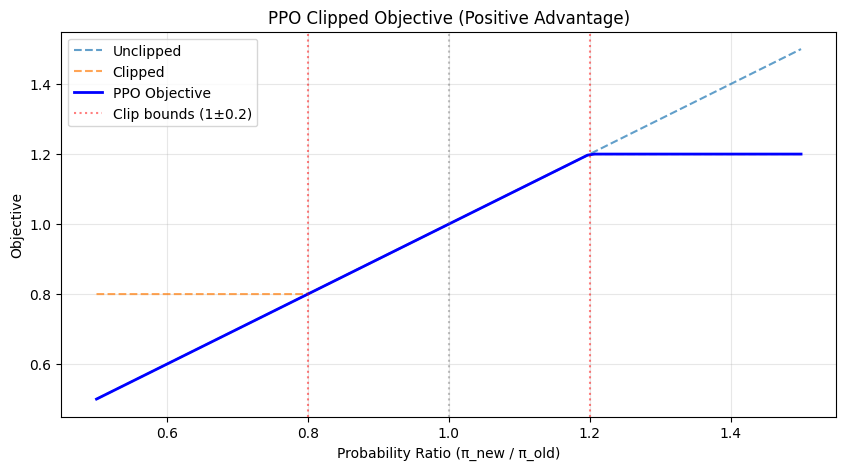

Key insight: Once ratio exceeds 1+ε, gradient becomes zero!
This prevents overshooting and catastrophic policy changes.


In [2]:
# Visualize PPO clipping for positive advantage
ratio = np.linspace(0.5, 1.5, 100)
epsilon = 0.2
advantage = 1.0  # Positive advantage

unclipped = ratio * advantage
clipped_ratio = np.clip(ratio, 1 - epsilon, 1 + epsilon)
clipped = clipped_ratio * advantage
ppo_objective = np.minimum(unclipped, clipped)

plt.figure(figsize=(10, 5))
plt.plot(ratio, unclipped, '--', label='Unclipped', alpha=0.7)
plt.plot(ratio, clipped, '--', label='Clipped', alpha=0.7)
plt.plot(ratio, ppo_objective, 'b-', linewidth=2, label='PPO Objective')
plt.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x=1-epsilon, color='red', linestyle=':', alpha=0.5, label=f'Clip bounds (1±{epsilon})')
plt.axvline(x=1+epsilon, color='red', linestyle=':', alpha=0.5)
plt.xlabel('Probability Ratio (π_new / π_old)')
plt.ylabel('Objective')
plt.title('PPO Clipped Objective (Positive Advantage)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Key insight: Once ratio exceeds 1+ε, gradient becomes zero!")
print("This prevents overshooting and catastrophic policy changes.")

## Value Function Loss

PPO also trains a value network to predict returns:

$$L^V(\theta) = \mathbb{E}_t \left[ (V_\theta(s_t) - \hat{R}_t)^2 \right]$$

In [3]:
def compute_value_loss(
    values: torch.Tensor,
    returns: torch.Tensor,
    old_values: torch.Tensor = None,
    clip_value: bool = True,
    clip_ratio: float = 0.2
) -> torch.Tensor:
    """
    Compute value function loss (optionally clipped).
    """
    if clip_value and old_values is not None:
        # Clipped value loss
        value_clipped = old_values + torch.clamp(
            values - old_values, -clip_ratio, clip_ratio
        )
        loss_unclipped = (values - returns) ** 2
        loss_clipped = (value_clipped - returns) ** 2
        loss = torch.max(loss_unclipped, loss_clipped).mean()
    else:
        # Standard MSE
        loss = F.mse_loss(values, returns)
    
    return loss

# Example
values = torch.randn(batch_size)
returns = torch.randn(batch_size)
old_values = values + torch.randn(batch_size) * 0.1

value_loss = compute_value_loss(values, returns, old_values)
print(f"Value Loss: {value_loss.item():.4f}")

Value Loss: 1.2130


## Entropy Bonus

To encourage exploration, PPO adds an entropy bonus:

$$H(\pi_\theta) = -\mathbb{E}_{a \sim \pi_\theta} [\log \pi_\theta(a | s)]$$

In [4]:
def compute_entropy(
    logits: torch.Tensor
) -> torch.Tensor:
    """
    Compute entropy of policy distribution.
    
    High entropy = more exploration
    Low entropy = more deterministic
    """
    probs = F.softmax(logits, dim=-1)
    log_probs = F.log_softmax(logits, dim=-1)
    entropy = -(probs * log_probs).sum(dim=-1)
    return entropy.mean()

# Example
logits = torch.randn(batch_size, 1000)  # vocab_size = 1000
entropy = compute_entropy(logits)
print(f"Entropy: {entropy.item():.4f}")

Entropy: 6.4175


## Complete PPO Loss

In [5]:
def compute_ppo_total_loss(
    policy_logprobs: torch.Tensor,
    old_logprobs: torch.Tensor,
    advantages: torch.Tensor,
    values: torch.Tensor,
    returns: torch.Tensor,
    logits: torch.Tensor,
    clip_ratio: float = 0.2,
    vf_coef: float = 0.5,
    entropy_coef: float = 0.01
) -> dict:
    """
    Compute total PPO loss combining all components.
    
    Total = Policy Loss + vf_coef * Value Loss - entropy_coef * Entropy
    """
    # Policy loss
    policy_loss = compute_ppo_loss(policy_logprobs, old_logprobs, advantages, clip_ratio)
    
    # Value loss
    value_loss = compute_value_loss(values, returns)
    
    # Entropy bonus
    entropy = compute_entropy(logits)
    
    # Total loss
    total_loss = policy_loss + vf_coef * value_loss - entropy_coef * entropy
    
    return {
        'total_loss': total_loss,
        'policy_loss': policy_loss,
        'value_loss': value_loss,
        'entropy': entropy
    }

print("PPO Total Loss = Policy Loss + 0.5 * Value Loss - 0.01 * Entropy")

PPO Total Loss = Policy Loss + 0.5 * Value Loss - 0.01 * Entropy


## PPO Hyperparameters

| Parameter | Default | Effect |
|-----------|---------|--------|
| `clip_ratio` (ε) | 0.2 | Higher = more aggressive updates |
| `vf_coef` | 0.5 | Value function loss weight |
| `entropy_coef` | 0.01 | Exploration encouragement |
| `ppo_epochs` | 4 | Reuses per rollout batch |

## Next Steps

Now let's learn about the KL penalty — why preventing drift from the reference model is essential for stable RLHF.